# In use Code

**This is a template code for a simple siamese network, made with tensorlow. Needs some work before it can be trained.**

In [ ]:
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import os, sys
import glob
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,butter, sosfiltfilt, sosfreqz
from sklearn.preprocessing import RobustScaler
from scipy import signal
from PIL import Image

import librosa
from tqdm import tqdm
import random

In [ ]:

#to-do before training

'''
1. Pre-processing code to get cleaned data
  a. re-sampling
  b. filtering
  c. outlier removal
  d. median filter
2. Windowing code -------------------------------- DONE
3. Image generation (12 channel)
4. Pairing code ---------------------------------- DONE
'''

'\n1. Pre-processing code to get cleaned data\n  a. re-sampling\n  b. filtering\n  c. outlier removal\n  d. median filter\n2. Windowing code -------------------------------- DONE\n3. Image generation (12 channel)\n4. Pairing code ---------------------------------- DONE\n'

In [ ]:
#### Import data

In [ ]:
!unzip "authentiear_data.zip"

Archive:  authentiear_data.zip
  inflating: P01/P01-1ACC1.csv       
 extracting: P01/P01-1ACC1.csv_acc_info.txt  
  inflating: P01/P01-1ACC2.csv       
 extracting: P01/P01-1ACC2.csv_acc_info.txt  
  inflating: P01/P01-2ACC1.csv       
 extracting: P01/P01-2ACC1.csv_acc_info.txt  
  inflating: P01/P01-2ACC2.csv       
 extracting: P01/P01-2ACC2.csv_acc_info.txt  
  inflating: P01/P01-3ACC1.csv       
 extracting: P01/P01-3ACC1.csv_acc_info.txt  
  inflating: P01/P01-3ACC2.csv       
 extracting: P01/P01-3ACC2.csv_acc_info.txt  
  inflating: P01/P01-4ACC1.csv       
 extracting: P01/P01-4ACC1.csv_acc_info.txt  
  inflating: P01/P01-4ACC2.csv       
 extracting: P01/P01-4ACC2.csv_acc_info.txt  
  inflating: P01/P01-5ACC1.csv       
 extracting: P01/P01-5ACC1.csv_acc_info.txt  
  inflating: P01/P01-5ACC2.csv       
 extracting: P01/P01-5ACC2.csv_acc_info.txt  
  inflating: P01/P01-7ACC1.csv       
 extracting: P01/P01-7ACC1.csv_acc_info.txt  
  inflating: P01/P01-7ACC2.csv       
 extrac

In [ ]:
##### Pre-processing

## Resampling
## Bandpass filtering
## Outliers


**Windowing Code**

In [ ]:
def window_data(data, fs, s, ov):
    """
    Windows a 1d np array of timeseries data into s second frames with ov percentage of overlap.
    Needs to be applied along every column

    Args:
        data: 1d np array of timeseries data.
        fs: Sampling rate in Hz.
        s: Window length in seconds.
        ov: Overlap rate as decimal point.

    Returns:
        2d np array of windowed data.
    """

    # Calculate the window length in samples.
    window_length = int(fs * s)

    # Calculate the overlap length in samples.
    overlap_length = int(window_length * ov)

    # Calculate the number of windows
    num_windows = int(np.ceil((len(data) - window_length) / (window_length - overlap_length))) + 1

    # Initialize the output array.
    windowed_data = np.zeros((num_windows, window_length))

    # Loop over the data and window it.
    for i in range(num_windows):
        start_index = i * (window_length - overlap_length)
        end_index = min(start_index + window_length, len(data))
        windowed_data[i, :end_index - start_index] = data[start_index:end_index]

    return windowed_data

In [ ]:
# window_data(np.array([1,2,3,4,5,6,7,8,9,10]),2,2,0.5)

**Pre-processing**



In [ ]:
def pre_process(file_dir,person,order,lowcut,highcut,fs,s,ov):

  '''
  Args:
    file_dir: directory of all unzipped files
    person: person identifier. e.g. "P05"
    order: bpass filter order
    lowcut: low freq threshold for bpass
    highcut: high freq threshold for bpass
    fs: sampling frequency
    s: windowing time in second
    ov: overlap rate in decimal point
  Returns:
    windows of preprocessed data. (12 2D np arrays in a list, each 2D array has 1D windows from one column in the csv)
  '''

  # scan and list all files
  all_files = glob.glob(file_dir+"/**/*.csv",recursive=True)
  target_files = [x for x in all_files if person in x]
  print(target_files)
  data_l = [x for x in target_files if "ACC1" in x]
  data_r = [x for x in target_files if "ACC2" in x]

  # read left and right data
# read left and right data
  L=[]
  R=[]
  s_rate = str(int(1000/fs))+"ms"

  for idx in range(len(data_l)):
      L_=pd.read_csv(data_l[idx],names = ["timestamp","Ax","Ay","Az","Gx","Gy","Gz"])
      R_=pd.read_csv(data_r[idx],names = ["timestamp","Ax","Ay","Az","Gx","Gy","Gz"])

      # assign timestamp as index
      L_['timestamp'] = pd.to_datetime(L_['timestamp'], unit='ms')
      R_['timestamp'] = pd.to_datetime(R_['timestamp'], unit='ms')
      L_ = L_.set_index('timestamp')
      R_ = R_.set_index('timestamp')

      # resample files from both sensors to match up the values
      #https://stackoverflow.com/questions/17001389/pandas-resample-documentation
      L_=L_.resample(s_rate).mean()
      R_=R_.resample(s_rate).mean()

      # interpolate
      L_ = L_.interpolate(method="linear",axis=0)
      R_ = R_.interpolate(method="linear",axis=0)

      L.append(L_)
      R.append(R_)

  L = pd.concat(L)
  R = pd.concat(R)

  #pre-process (bandpass filter, windowing)
  data = []

  sos = butter(N=order, Wn=[lowcut,highcut], btype='bandpass', fs=fs, output='sos', analog=False)
  transformer = RobustScaler()

  for col in L.columns:
      signal = sosfiltfilt(sos, L[col])
      # signal = transformer.fit_transform(signal)
      data.append(window_data(np.array(signal),fs,s,ov))
  for col in R.columns:
      signal = sosfiltfilt(sos, R[col])
      # signal = transformer.fit_transform(signal)
      data.append(window_data(np.array(signal),fs,s,ov))

  return data

In [ ]:
p1_data = pre_process("/content/","P01",2,10,200,500,15,0.2)
p2_data = pre_process("/content/","P02",2,10,200,500,15,0.2)
# !ls

['/content/P01/P01-3ACC2.csv', '/content/P01/P01-1ACC2.csv', '/content/P01/P01-5ACC1.csv', '/content/P01/P01-3ACC1.csv', '/content/P01/P01-2ACC1.csv', '/content/P01/P01-7ACC2.csv', '/content/P01/P01-1ACC1.csv', '/content/P01/P01-5ACC2.csv', '/content/P01/P01-4ACC1.csv', '/content/P01/P01-4ACC2.csv', '/content/P01/P01-7ACC1.csv', '/content/P01/P01-2ACC2.csv']
['/content/P02/P02-2ACC1.csv', '/content/P02/P02-6ACC2.csv', '/content/P02/P02-1ACC1.csv', '/content/P02/P02-7ACC1.csv', '/content/P02/P02-5ACC2.csv', '/content/P02/P02-1ACC2.csv', '/content/P02/P02-5ACC1.csv', '/content/P02/P02-6ACC1.csv', '/content/P02/P02-4ACC2.csv', '/content/P02/P02-7ACC2.csv', '/content/P02/P02-2ACC2.csv', '/content/P02/P02-3ACC1.csv', '/content/P02/P02-3ACC2.csv', '/content/P02/P02-4ACC1.csv']


**Image generation**

In [ ]:
def generate_image_2(data, fs=500, window_size=0.1, overlap=0.5, target_size=(64, 64)):

  num_channels = 12
  num_windows = data[0].shape[0]
  all_images = []

  nperseg = int(window_size * fs)
  noverlap = int(nperseg * overlap)

  for i in tqdm(range(data[0].shape[0])):
  # for i in tqdm(range(5)):
    combined_image = []
    for j in range(12):
      # p5_data[j][i]
      f, t, Sxx = signal.spectrogram(data[j][i], 500, window='hamming', nperseg=nperseg, noverlap=overlap)
      Sxx_dB = 10 * np.log10(Sxx)
      # Normalize the dB values to 0-255 for grayscale image
      Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
      # Convert to uint8
      Sxx_img = Sxx_norm.astype(np.uint8)
      # Resize image to target size
      img = Image.fromarray(Sxx_img)
      img_resized = img.resize(target_size)
      # Add to combined image
      # plt.figure(figsize=(3, 3))
      # plt.imshow(img_resized)
      # plt.axis('off')
      # plt.title(f'Channel {i+1}')
      # plt.show()
      combined_image.append(np.array(img_resized))
      # print(len(combined_image))
    # Stack images along the last axis to create a 12-channel image
    combined_image = np.stack(combined_image, axis=2)
    # print(combined_image.shape)
    # save images to master list
    all_images.append(combined_image)

  return all_images

In [ ]:
# p_1_images = generate_image_2(p1_data)
# p_2_images = generate_image_2(p2_data)

**Pair Generation**

In [ ]:
def get_pairs(lists, pos, neg):
  X1 = []
  X2 = []
  y = []

  for idx in range(pos+neg):
   #for positive, take from same list
    list_a = lists[random.randint(0,len(lists)-1)]

    X1.append(list_a[random.randint(0,len(list_a)-1)])
    X2.append(list_a[random.randint(0,len(list_a)-1)])
    y.append(0)

   #for negative, take from different lists
    ind_1 = random.randint(0,len(lists)-1)
    ind_2 = random.randint(0,len(lists)-1)
    while ind_1 == ind_2:
      ind_2 = random.randint(0,len(lists)-1)

    list_a = lists[ind_1]
    list_b = lists[ind_2]

    X1.append(list_a[random.randint(0,len(list_a)-1)])
    X2.append(list_b[random.randint(0,len(list_b)-1)])
    y.append(1)

  return X1,X2, y

In [ ]:
# x1,x2,y = get_pairs([p_1_images,p_2_images], 5,5)

**Triplet Generation**

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

# Sample lists (replace with your actual data)
lists = [["apple", "banana", "cherry"], ["red", "green", "blue"], ["dog", "cat", "fish"]]

dummy_data = []
for i in range(len(lists)):
  for x in lists[i]:
    dummy_data.append((i, x))
print(dummy_data)

df = pd.DataFrame(dummy_data, columns=['label','data'])
display(df)

def get_triplets(df):
  triplets = []
  labels = df['label'].unique()

  grouped = df.groupby('label')
  for label, group in grouped:
        # Extract samples and their indices for this class
        samples = group.drop(columns=['label']).values
        indices = group.index.values

        # Generate all possible combinations of anchor, positive, and negative samples
        for anchor_index, positive_index in combinations(range(len(samples)), 2):
            anchor = samples[anchor_index][0]
            positive = samples[positive_index][0]

            # Select negative samples from other classes
            other_classes = [grp.drop(columns=['label']).values for lbl, grp in grouped if lbl != label]
            for other_class in other_classes:
                for negative in other_class:
                    triplets.append((anchor, positive, negative[0]))

  return np.array(triplets)

triplets = get_triplets(df)
print(triplets)

[(0, 'apple'), (0, 'banana'), (0, 'cherry'), (1, 'red'), (1, 'green'), (1, 'blue'), (2, 'dog'), (2, 'cat'), (2, 'fish')]


,label,data
0,0,apple
1,0,banana
2,0,cherry
3,1,red
4,1,green
5,1,blue
6,2,dog
7,2,cat
8,2,fish


[['apple' 'banana' 'red']
 ['apple' 'banana' 'green']
 ['apple' 'banana' 'blue']
 ['apple' 'banana' 'dog']
 ['apple' 'banana' 'cat']
 ['apple' 'banana' 'fish']
 ['apple' 'cherry' 'red']
 ['apple' 'cherry' 'green']
 ['apple' 'cherry' 'blue']
 ['apple' 'cherry' 'dog']
 ['apple' 'cherry' 'cat']
 ['apple' 'cherry' 'fish']
 ['banana' 'cherry' 'red']
 ['banana' 'cherry' 'green']
 ['banana' 'cherry' 'blue']
 ['banana' 'cherry' 'dog']
 ['banana' 'cherry' 'cat']
 ['banana' 'cherry' 'fish']
 ['red' 'green' 'apple']
 ['red' 'green' 'banana']
 ['red' 'green' 'cherry']
 ['red' 'green' 'dog']
 ['red' 'green' 'cat']
 ['red' 'green' 'fish']
 ['red' 'blue' 'apple']
 ['red' 'blue' 'banana']
 ['red' 'blue' 'cherry']
 ['red' 'blue' 'dog']
 ['red' 'blue' 'cat']
 ['red' 'blue' 'fish']
 ['green' 'blue' 'apple']
 ['green' 'blue' 'banana']
 ['green' 'blue' 'cherry']
 ['green' 'blue' 'dog']
 ['green' 'blue' 'cat']
 ['green' 'blue' 'fish']
 ['dog' 'cat' 'apple']
 ['dog' 'cat' 'banana']
 ['dog' 'cat' 'cherry']
 [

This model takes as input images of dimension 28\*28\*3 . This should be changed to fit our needs.

Better loss than mse should also be integrated.

In [ ]:
#Get the base model for siamese network
input_layer = Input((64, 64, 12))
layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer2)
layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
layer5 = Flatten()(layer4)
embeddings = Dense(16, activation=None)(layer5)
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = Model(inputs=input_layer, outputs=norm_embeddings)


# Create left and right twin models
input1 = Input((64,64,12))
input2 = Input((64,64,12))

left_model = model(input1)
right_model = model(input2)

# Dot product layer
#Change to a classifier or small ann in the future
dot_product = dot([left_model, right_model], axes=1, normalize=False)

#Get the siamese network
siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

print(siamese_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 12)]         0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 64, 64, 12)]         0         []                            
                                                                                                  
 model (Functional)          (None, 16)                   156528    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 dot (Dot)                   (None, 1)                    0         ['model[0][0]',         

In [ ]:

""" Triplet Loss Model"""


def triplet_loss(y_true, y_pred, alpha=0.175):
    """
    Triplet loss function.

    Parameters:
        y_true: true labels, not used in the loss function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.

    Returns:
        Triplet loss value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet loss calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    return K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0))

def triplet_loss_r(y_true, y_pred, alpha=0.175, beta = 0.2):
    """
    Triplet loss function.001

    Parameters:
        y_true: true labels, not used in the loss function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.

    Returns:
        Triplet loss value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet loss calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    triplet_loss = K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0))

    # Regularization term to penalize large distances for positive examples
    positive_regularization = K.mean(K.maximum(K.square(positive_distance) - beta, 0.0))
     # Regularization term to penalize small distances for negative examples
    negative_regularization = K.mean(K.maximum(beta- K.square(negative_distance), 0.0))

    return triplet_loss + positive_regularization + negative_regularization



def triplet_accuracy(y_true, y_pred, alpha=0.175):
    """
    Triplet accuracy function.

    Parameters:
        y_true: true labels, not used in the accuracy function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.

    Returns:
        Triplet accuracy value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet accuracy calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    print(positive_distance,negative_distance)
    return K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0) == 0.0)



In [ ]:
# Model definition
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, Layer, concatenate

input_anchor = Input((64, 64, 12))
input_positive = Input((64, 64, 12))
input_negative = Input((64, 64, 12))

embedding_anchor = model(input_anchor)
embedding_positive = model(input_positive)
embedding_negative = model(input_negative)

triplet_loss_output = concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

# Triplet loss model
siamese_triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=triplet_loss_output)

base_learning_rate = 0.01
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
siamese_triplet_model.compile(loss=triplet_loss, optimizer=optimizer, metrics = [triplet_accuracy])

print(siamese_triplet_model.summary())
'''Train the Model'''


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64, 64, 12)]         0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 64, 64, 12)]         0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 64, 64, 12)]         0         []                            
                                                                                                  
 model (Functional)          (None, 16)                   156528    ['input_10[0][0]',            
                                                                     'input_11[0][0]',      

'Train the Model'

# Wrapper code for functions

In [ ]:
file_directory = "/content/"
# persons = ["P01","P02","P03","P05"]
persons = ["P01","P02"]

#pre-process parameters
order = 2
lowcut = 10
highcut = 200
fs = 500
s = 30
ov = 0.2

#training_set parameters
pos = 5
neg = 5

#training parameters

epochs = 5
batch_size = 5
loss = 'mse'
validation_split = 0.2

In [ ]:
prprcs_data = []
for prsn in persons:
  prprcs_data.append(pre_process("/content/",prsn,order,lowcut,highcut,fs,s,ov))

images = []
for x in prprcs_data:
  try:
    images.append(generate_image_2(x))
  except:
    print("skipped an image")

X1,X2,y = get_pairs(images,pos,neg)

['/content/P01/P01-3ACC2.csv', '/content/P01/P01-1ACC2.csv', '/content/P01/P01-5ACC1.csv', '/content/P01/P01-3ACC1.csv', '/content/P01/P01-2ACC1.csv', '/content/P01/P01-7ACC2.csv', '/content/P01/P01-1ACC1.csv', '/content/P01/P01-5ACC2.csv', '/content/P01/P01-4ACC1.csv', '/content/P01/P01-4ACC2.csv', '/content/P01/P01-7ACC1.csv', '/content/P01/P01-2ACC2.csv']
['/content/P02/P02-2ACC1.csv', '/content/P02/P02-6ACC2.csv', '/content/P02/P02-1ACC1.csv', '/content/P02/P02-7ACC1.csv', '/content/P02/P02-5ACC2.csv', '/content/P02/P02-1ACC2.csv', '/content/P02/P02-5ACC1.csv', '/content/P02/P02-6ACC1.csv', '/content/P02/P02-4ACC2.csv', '/content/P02/P02-7ACC2.csv', '/content/P02/P02-2ACC2.csv', '/content/P02/P02-3ACC1.csv', '/content/P02/P02-3ACC2.csv', '/content/P02/P02-4ACC1.csv']


 94%|█████████▍| 99/105 [00:01<00:00, 84.14it/s]<ipython-input-10-dd23c7c1f4a3>:16: RuntimeWarning: divide by zero encountered in log10
  Sxx_dB = 10 * np.log10(Sxx)
<ipython-input-10-dd23c7c1f4a3>:18: RuntimeWarning: invalid value encountered in subtract
  Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
<ipython-input-10-dd23c7c1f4a3>:18: RuntimeWarning: invalid value encountered in divide
  Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
<ipython-input-10-dd23c7c1f4a3>:20: RuntimeWarning: invalid value encountered in cast
  Sxx_img = Sxx_norm.astype(np.uint8)
100%|██████████| 123/123 [00:01<00:00, 82.71it/s]


In [ ]:
#compile and fit model
siamese_model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = 'accuracy')
history = siamese_model.fit([np.array(X1), np.array(X2)], np.array(y),
                            validation_split = validation_split, epochs=epochs,
                            batch_size=batch_size, shuffle=True, verbose=True)

Epoch 1/5
4/4 [==============================] - 3s 290ms/step - loss: 1.2598 - accuracy: 0.5625 - val_loss: 2.2932 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 1s 174ms/step - loss: 1.3753 - accuracy: 0.5000 - val_loss: 2.0046 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 1s 226ms/step - loss: 0.6512 - accuracy: 0.5625 - val_loss: 2.1017 - val_accuracy: 0.5000
Epoch 4/5
4/4 [==============================] - 1s 154ms/step - loss: 0.9633 - accuracy: 0.5625 - val_loss: 2.2793 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 1s 141ms/step - loss: 1.0057 - accuracy: 0.6875 - val_loss: 1.4797 - val_accuracy: 0.5000


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#save the models

model.save(os.getcwd()+"/base_model.h5")
siamese_model.save(os.getcwd()+"/full_network.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Plots**

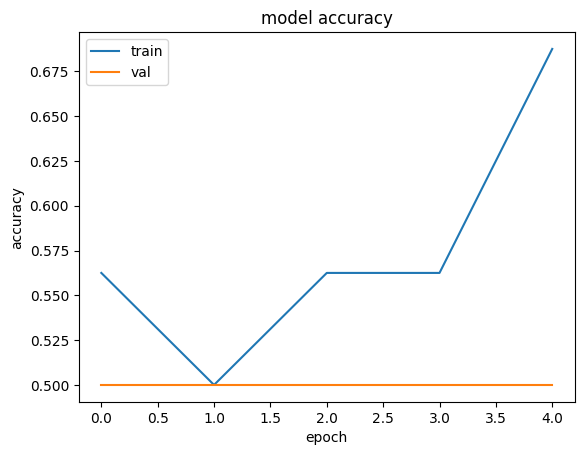

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

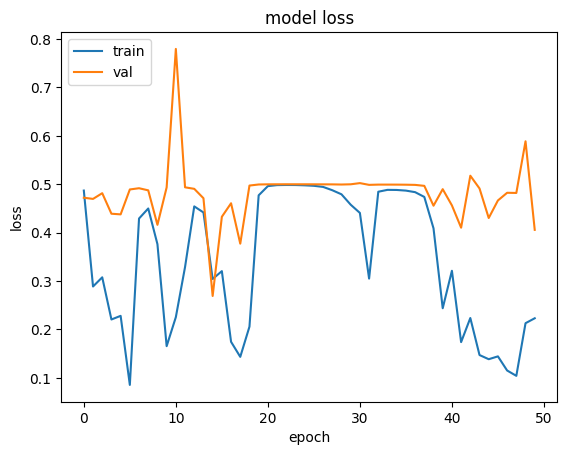

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

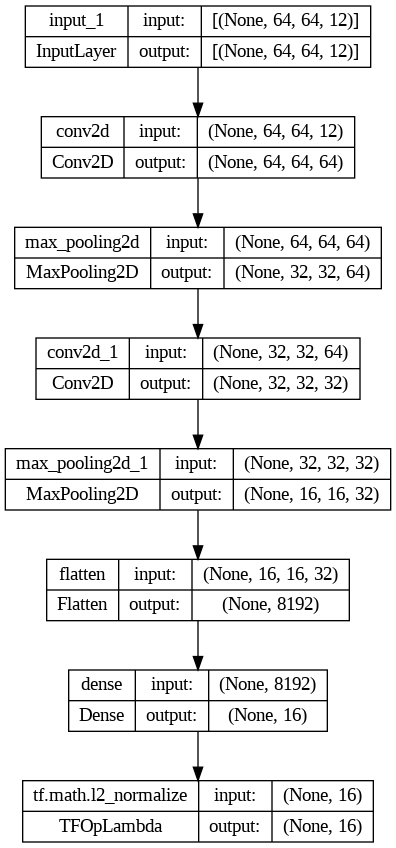

In [ ]:
plot_model(model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)


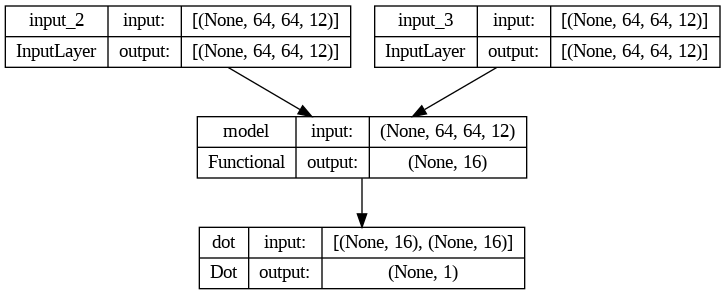

In [ ]:
plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)

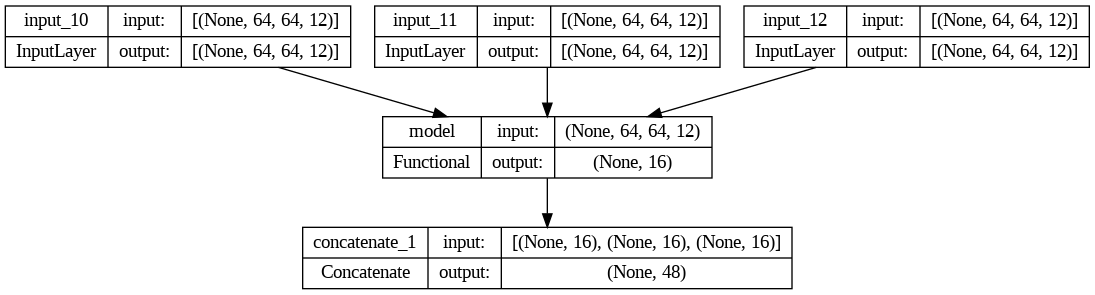

In [ ]:
plot_model(siamese_triplet_model, to_file=os.getcwd()+'/siamese_triplet_model_mnist.png', show_shapes=1, show_layer_names=1)

**Testing**

In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Load models
# model = load_model(os.getcwd()+"/bse_model.h5")
# siamese_model = load_model(os.getcwd()+"/full_network.h5")

# similarity_scores = siamese_model.predict([np.array(X1_test), np.array(X2_test)])
# threshold = 0.7
# predicted_labels = (similarity_scores > threshold).astype(int)
# accuracy = accuracy_score(y_test, predicted_labels)
# precision = precision_score(y_test, predicted_labels)
# recall = recall_score(y_test, predicted_labels)
# f1 = f1_score(y_test, predicted_labels)

In [ ]:
def get_far_frr(y_true, y_pred):
  '''
  y_true: actual labels of data (0 if user should be granted access,
                                1 if user should be denied access)
  y_pred: predicted labels of data

  returns: False Acceptance Rate and False Rejection Rate based on given
  actual and predicted labels of the data
  '''
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i] == 0:
      tp += 1
    elif y_true[i] == y_pred[i] == 1:
      tn += 1
    elif y_pred[i] == 0:
      fp += 1
    elif y_pred[i] == 1:
      fn += 1
  return fp/(fp+tn), fn/(fn+tp)

# Old code and resources

These are some useful links I found:

1. https://medium.com/@rinkinag24/a-comprehensive-guide-to-siamese-neural-networks-3358658c0513
2. https://builtin.com/machine-learning/siamese-network
3. https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee
4. https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

<ipython-input-22-81d813decb24>:4: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(stft,


(1025, 9)


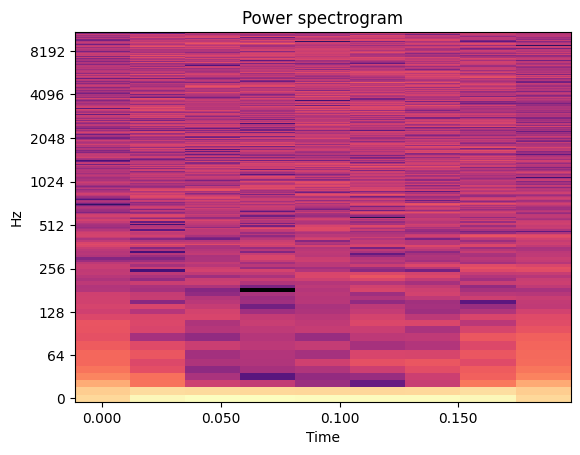

In [ ]:
stft = librosa.stft(np.random.rand(64,64).reshape(-1)) #nfft,hop_length,win_length: returns 2D array
# to display graph
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')

print(stft.shape)

In [ ]:
'''
Get lists of paths for each image from each person to make a list. Then make a list of all those lists.

Later we need to randomly choose equal number of positive and negative pairs.
'''


def get_positive_pairs(lists):
  """
  This function takes a list of lists (each containing strings) and returns
  a list of all possible positive pairs (strings from the same list).
  """
  positive_pairs = []
  for string_list in lists:
    for i in range(len(string_list)):
      for j in range(i + 1, len(string_list)):
        positive_pairs.append((string_list[i], string_list[j]))
  return positive_pairs

def get_negative_pairs(lists):
  """
  This function takes a list of lists (each containing strings) and returns
  a list of all possible negative pairs (strings from different lists).
  """
  negative_pairs = []
  for i in range(len(lists)):
    for j in range(i + 1, len(lists)):
      for string1 in lists[i]:
        for string2 in lists[j]:
          negative_pairs.append((string1, string2))
  return negative_pairs


# Sample lists (replace with your actual data)
lists = [["apple", "banana", "cherry"], ["red", "green", "blue"], ["dog", "cat", "fish"]]

# Get positive pairs
positive_pairs = get_positive_pairs(lists)
print(positive_pairs)

# Get negative pairs
negative_pairs = get_negative_pairs(lists)
print(negative_pairs)


[('apple', 'banana'), ('apple', 'cherry'), ('banana', 'cherry'), ('red', 'green'), ('red', 'blue'), ('green', 'blue'), ('dog', 'cat'), ('dog', 'fish'), ('cat', 'fish')]
[('apple', 'red'), ('apple', 'green'), ('apple', 'blue'), ('banana', 'red'), ('banana', 'green'), ('banana', 'blue'), ('cherry', 'red'), ('cherry', 'green'), ('cherry', 'blue'), ('apple', 'dog'), ('apple', 'cat'), ('apple', 'fish'), ('banana', 'dog'), ('banana', 'cat'), ('banana', 'fish'), ('cherry', 'dog'), ('cherry', 'cat'), ('cherry', 'fish'), ('red', 'dog'), ('red', 'cat'), ('red', 'fish'), ('green', 'dog'), ('green', 'cat'), ('green', 'fish'), ('blue', 'dog'), ('blue', 'cat'), ('blue', 'fish')]


In [ ]:
# #GPTs model

# # Create the model
# model = tf.keras.Sequential()

# # Layer 1: Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 12)))

# # Layer 2: Max-pooling layer with 2x2 pool size
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Layer 3: Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
# model.add(Conv2D(32, (3, 3), activation='relu'))

# # Layer 4: Max-pooling layer with 2x2 pool size
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Layer 5: Flatten layer to convert 2D feature maps to 1D vector
# model.add(Flatten())

# # Output layer: Fully connected layer with 16 units (for 16 classes or features)
# model.add(Dense(16, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Summary of the model architecture
# model.summary()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal
# from PIL import Image

def generate_image(data, fs, window_size=0.1, overlap=0.5, target_size=(64, 64)):
    """
    Generate spectrogram plots for each column of sensor data and combine them into a 12-channel image.

    Args:
        data: Windowed sensor data. Shape: (window_data_size, num_channels)
        fs: Sampling frequency
        window_size: Width of the window in seconds
        overlap: Overlap between consecutive windows (0 to 1)
        target_size: Target size for each spectrogram image

    Returns:
        A 12-channel image combined from spectrogram plots.
    """
    # num_channels = data.shape[1]
    num_channels = 12
    num_windows = data[0].shape[0]
    combined_image = []

    # Calculate the number of samples per window
    nperseg = int(window_size * fs)
    # Calculate the overlap in samples
    noverlap = int(nperseg * overlap)

    for i in range(num_channels):
        f, t, Sxx = signal.spectrogram(data[:, i], fs, window='hamming', nperseg=nperseg, noverlap=noverlap)

        # Convert spectrogram to dB scale
        Sxx_dB = 10 * np.log10(Sxx)

        # Normalize the dB values to 0-255 for grayscale image
        Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
        # Convert to uint8
        Sxx_img = Sxx_norm.astype(np.uint8)

        # Resize image to target size
        img = Image.fromarray(Sxx_img)
        img_resized = img.resize(target_size)

        # Plot and show the resized image
        plt.figure(figsize=(3, 3))
        plt.imshow(img_resized)
        plt.axis('off')
        plt.title(f'Channel {i+1}')
        plt.show()

        # Add to combined image
        combined_image.append(np.array(img_resized))

    # Stack images along the last axis to create a 12-channel image
    combined_image = np.stack(combined_image, axis=-1)

    return combined_image
